### Preparations

1. Downloading the [Galaxy10 Dataset](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html)

In [1]:
!wget -c https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2023-08-09 13:53:00--  https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  14.1MB/s    in 16s     

2023-08-09 13:53:16 (12.5 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



2. Loading the galaxy images & labels from the downloaded file
3. Prepare image data (grayscale, crop, normalize)
4. Shuffle images & labels the same way

In [2]:
import h5py
import numpy as np

# Get galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  images = np.array(F["images"])

# turn color into grayscale
images = images.mean(axis=-1, keepdims=True)
# crop the images 64x64 pixels
images = images[:, 2:66, 2:66, :]
# normalize intensity from 0...255 to 0...1.0
images = images.astype(np.float32) / 255.

# shuffle once
shuffle_idx = np.random.default_rng(seed=123).permutation(len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

# show shape
print(f"{images.shape=} {labels.shape=}")

images.shape=(21785, 64, 64, 1) labels.shape=(21785,)


5. Two plotting helpers `show_galaxies` and `show_confusion` with usage example

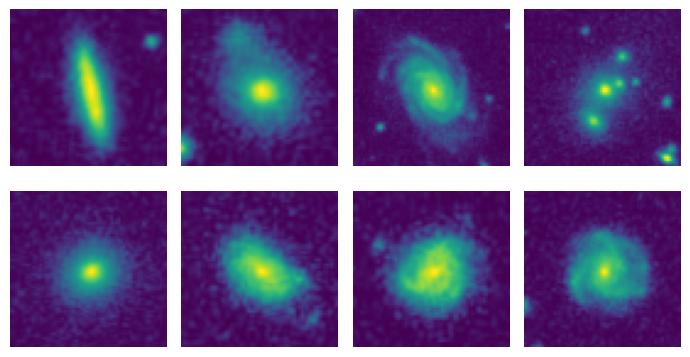

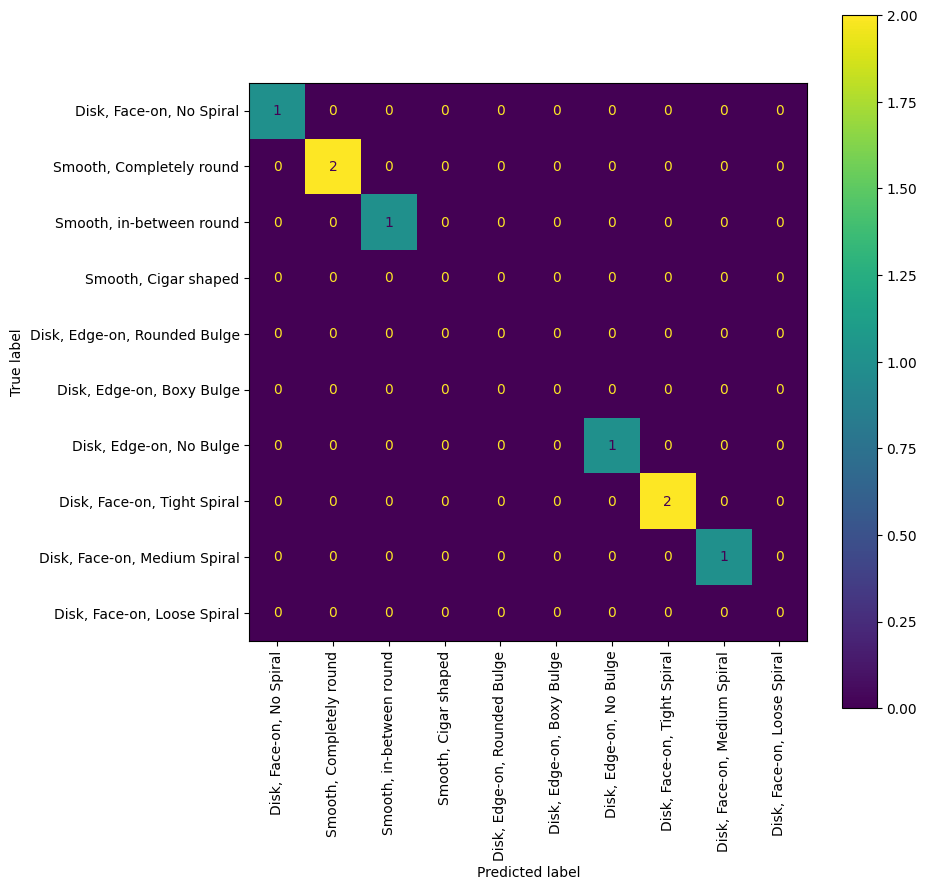

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

def show_galaxies(images, ncols=4):
  """
  shows the given `images`
    optionally the number of columns (`ncols`) can be adjusted
  """
  assert 0 < ncols == int(ncols)
  n = len(images)
  nrows = -(-n // ncols) # ceil integer  division
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 4))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
  fig.tight_layout()

label_names = [
  "Disk, Face-on, No Spiral",
  "Smooth, Completely round",
  "Smooth, in-between round",
  "Smooth, Cigar shaped",
  "Disk, Edge-on, Rounded Bulge",
  "Disk, Edge-on, Boxy Bulge",
  "Disk, Edge-on, No Bulge",
  "Disk, Face-on, Tight Spiral",
  "Disk, Face-on, Medium Spiral",
  "Disk, Face-on, Loose Spiral",
]

def show_confusion(true_labels, predicted_labels, normalize=None):
  """
  shows the confusion matrix for the given `true_labels` and `predicted_labels`
    optionally can `normalize` for either "true" or "pred"icted label, or even globally ("all")
  """
  fig, axs = plt.subplots(figsize=(9, 9))
  ConfusionMatrixDisplay(
      confusion_matrix(
        y_true=true_labels,
        y_pred=predicted_labels,
        labels=np.arange(len(label_names)),
        normalize=normalize
      ),
      display_labels=label_names,
  ).plot(ax=axs, xticks_rotation="vertical")


# plot first 8 galaxies
show_galaxies(images[:8])

# plot a "perfect" confusion matrix for the first 8 galaxies
show_confusion(labels[:8], labels[:8])


## Primary Task:
- Train a neural network to classify the galaxy image’s shapes
- Invest some time into optimizing your network’s performance

## Questions:
1. How do you measure your network’s performance?
   - What is your reason for this choice?
   - What other good choices are there?
2. What makes Class 5 (Disk, Edge-on, Boxy Bulge) stand out?
   - How can this be addressed?
3. Find the galaxy images that your network performs best(worst) with. Explain why this is the case.

## Your solution

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
class GalaxyDataset(Dataset):
  def __init__(self, X):
    self.X = X
    self.convert = transforms.ToTensor()

  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.convert = transforms.ToTensor()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
        # Select sample
        image = self.X[index]
        X = self.convert(image)
        y = self.y[index]
        return X, y

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [43]:
N_train = 18000

x_train = images[:N_train,:,:,:]
y_train = labels[:N_train]
x_test = images[N_train:,:,:,:]
y_test = labels[N_train:]

data_train = GalaxyDataset(x_train,y_train)
data_test = GalaxyDataset(x_test,y_test)

batch_size = 64

# create dataset loaders from trainset and testset
kwargs = {'num_workers': 4, 'pin_memory': False,
          'batch_size': batch_size}
trainloader = DataLoader(
    data_train, shuffle=True, **kwargs)
testloader = DataLoader(
    data_test, shuffle=False, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
dataiter = iter(trainloader)

images, labels = next(dataiter)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


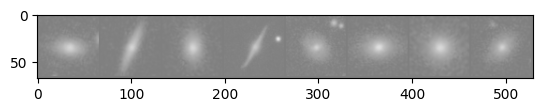

2 4 2 4 0 2 1 0


In [69]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(images[:images_to_plot]))
# print labels
print(' '.join(f'{labels[j]}' for j in range(images_to_plot)))

In [76]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #TODO: define the layers

        self.conv1 = nn.Conv2d(1,2,(2,2),stride=1,padding=1)
        self.conv2 = nn.Conv2d(2,4,(4,4),stride=2,padding=1)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.conv3 = nn.Conv2d(4,4,(4,4),stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(4,stride=2)
        self.conv4 = nn.Conv2d(4,4,(4,4),stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(4,stride=2)
        self.linear1 = nn.Linear(4, 64)
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(32,10)
        self.act1 = nn.ReLU()
        self.flat = nn.Flatten()
        self.act2 = nn.Softmax()

    def forward(self, x):

        #TODO: run layer

        x = self.act1(self.conv1(x))
        x = self.act1(self.conv2(x))
        x = self.pool1(x)
        x = self.act1(self.conv3(x))
        x = self.pool2(x)
        x = self.act1(self.conv4(x))
        x = self.flat(self.pool3(x))
        x = self.act1(self.linear1(x))
        x = self.act1(self.linear2(x))
        output = self.act2(self.linear3(x))
        return output

In [77]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
  (act1): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (act2): Softmax(dim=None)
)


In [78]:
summary(model, (1, 64, 64), batch_size=64, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 2, 65, 65]              10
              ReLU-2            [64, 2, 65, 65]               0
            Conv2d-3            [64, 4, 32, 32]             132
              ReLU-4            [64, 4, 32, 32]               0
         MaxPool2d-5            [64, 4, 15, 15]               0
            Conv2d-6            [64, 4, 14, 14]             260
              ReLU-7            [64, 4, 14, 14]               0
         MaxPool2d-8              [64, 4, 6, 6]               0
            Conv2d-9              [64, 4, 5, 5]             260
             ReLU-10              [64, 4, 5, 5]               0
        MaxPool2d-11              [64, 4, 1, 1]               0
          Flatten-12                    [64, 4]               0
           Linear-13                   [64, 64]             320
             ReLU-14                   

<ipython-input-76-107e9f85d36f>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.act2(self.linear3(x))


In [79]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [80]:
# move model to GPU
model = model.to(device)

In [81]:
learning_rate = 0.003
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

In [82]:
def train(num_epochs, model, trainloader, testloader):

    train_losses = []
    train_accuracy = []

    val_losses = []
    val_accuracy = []

    # Train the model
    for epoch in range(num_epochs):

        # training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(trainloader, 0):

            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)

            # run model
            output = model(images)
            # compute loss
            loss = loss_func(output, labels)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            # save metrics for ploting
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        # validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")

    print(f"Finished training after {num_epochs} epochs")
    print(f"Best validation accuracy: {max(val_accuracy)}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 50
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, model, trainloader, testloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-76-107e9f85d36f>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.act2(self.linear3(x))


Epoch: 1/50 | loss: 2.1287366633719587 - acc: 0.323082890070922 | val_loss: 2.0971720576286317 - val_acc: 0.36209490746259687
Epoch: 2/50 | loss: 2.0990286245413707 - acc: 0.35599512411347517 | val_loss: 2.0906898379325867 - val_acc: 0.36808449079593025
Epoch: 3/50 | loss: 2.092094895687509 - acc: 0.36336436170212766 | val_loss: 2.09090443054835 - val_acc: 0.3659722223877907
Epoch: 4/50 | loss: 2.082409293516308 - acc: 0.3711214539007092 | val_loss: 2.065069123109182 - val_acc: 0.3930844907959302
Epoch: 5/50 | loss: 2.060064011854483 - acc: 0.3982712765957447 | val_loss: 2.056433826684952 - val_acc: 0.3995949074625969
Epoch: 6/50 | loss: 2.0503630291485617 - acc: 0.4079676418439716 | val_loss: 2.078615834315618 - val_acc: 0.3761863430341085
Epoch: 7/50 | loss: 2.049266295230135 - acc: 0.4073581560283688 | val_loss: 2.0586994091669717 - val_acc: 0.39907407412926355
Epoch: 8/50 | loss: 2.0411360597779566 - acc: 0.41384086879432624 | val_loss: 2.0441423296928405 - val_acc: 0.4045428241292

In [83]:
# predicting labels for test data and calculating accuracy
correct = 0
total = 0
test_preds = []
test_labels = []
test_images = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        test_preds.append(predicted.cpu())
        test_labels.append(labels.cpu())
        test_images.append(images.cpu())
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_images = torch.cat(test_images)

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

<ipython-input-76-107e9f85d36f>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.act2(self.linear3(x))


Accuracy of the network on the 3785 test images: 55 %


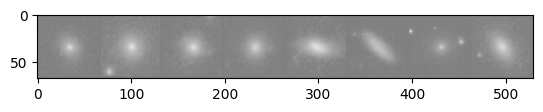

Truth:      Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, in-between round Smooth, Cigar shaped Smooth, Completely round Smooth, in-between round
Predicted:  Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round Smooth, Completely round


In [58]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(test_images[:images_to_plot]))
# print labels
print('Truth:     ', ' '.join(f'{label_names[test_labels[j]]}' for j in range(images_to_plot)))
print('Predicted: ', ' '.join(f'{label_names[test_preds[j]]}' for j in range(images_to_plot)))

In [63]:
print([test_labels[i] for i in range(1000)])

[1, 1, 1, 1, 2, 3, 1, 2, 2, 4, 2, 2, 2, 1, 2, 1, 9, 2, 0, 8, 1, 1, 0, 7, 6, 2, 3, 0, 2, 1, 8, 1, 3, 4, 7, 1, 2, 0, 2, 1, 2, 1, 2, 8, 4, 2, 2, 2, 1, 7, 1, 2, 6, 0, 1, 1, 2, 2, 2, 2, 4, 1, 2, 0, 1, 2, 9, 2, 1, 2, 2, 2, 1, 1, 0, 0, 1, 4, 0, 2, 2, 2, 1, 7, 4, 1, 1, 1, 0, 2, 1, 1, 1, 9, 2, 2, 9, 7, 1, 1, 0, 1, 0, 3, 1, 2, 2, 2, 0, 0, 0, 9, 0, 1, 2, 2, 9, 1, 1, 1, 7, 1, 1, 7, 0, 2, 5, 0, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 6, 7, 7, 2, 2, 0, 6, 2, 2, 7, 0, 2, 1, 6, 0, 1, 1, 2, 1, 2, 2, 1, 1, 8, 3, 1, 3, 2, 7, 0, 1, 4, 2, 8, 1, 2, 2, 8, 0, 0, 1, 1, 1, 4, 2, 0, 1, 1, 2, 3, 2, 0, 1, 2, 2, 0, 4, 5, 1, 2, 2, 9, 1, 1, 0, 2, 1, 2, 0, 2, 4, 0, 0, 8, 2, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0, 6, 1, 1, 1, 1, 1, 0, 2, 3, 1, 0, 2, 3, 1, 1, 0, 2, 2, 2, 7, 1, 8, 1, 2, 2, 4, 4, 7, 1, 4, 2, 2, 1, 7, 2, 8, 0, 8, 0, 4, 0, 9, 1, 2, 1, 1, 8, 0, 0, 1, 4, 1, 0, 1, 2, 1, 1, 0, 0, 2, 0, 1, 7, 2, 8, 1, 2, 7, 2, 8, 4, 2, 2, 2, 7, 2, 4, 4, 1, 0, 3, 2, 9, 1, 4, 2, 1, 4, 2, 1, 0, 0, 8, 1, 4, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 0, 